In [275]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.stats import kruskal
from sklearn.preprocessing import MinMaxScaler

# Basic Features

In [2]:
def get_basic_features(path):
    features, feature_names = [], []
    for stat in ["BVP", "HR", "EDA", "TEMP"]:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        features += [signal.min(), signal.max(), signal.mean(), signal.std()]
        feature_names += [f"{stat}_{f}" for f in ["min", "max", "mean", "std"]]
    return feature_names, features

In [3]:
metadata = pd.read_csv("metadata.csv")
basic_ds = []
for path in metadata['Path']:
    feature_names, features = get_basic_features(path)
    basic_ds.append(features)
    
basic_ds = pd.DataFrame(basic_ds, columns = feature_names)

In [4]:
X = basic_ds.values[:, 3:] #can only be poitive, and BVP can be negative too

In [5]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [6]:
X.shape

(312, 13)

In [7]:
H.shape

(2, 13)

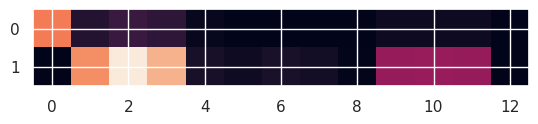

In [8]:
plt.imshow(H, interpolation='nearest')
plt.show()

In [9]:
(W@H).shape

(312, 13)

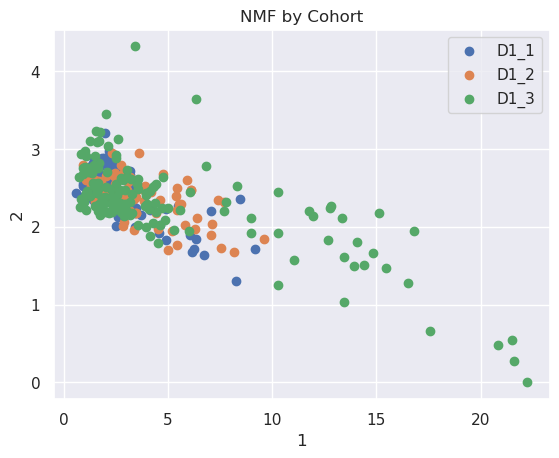

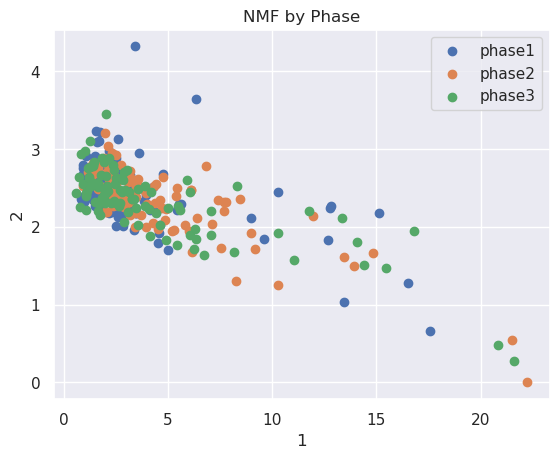

In [13]:
def visualize(meta, W, by_column):
    plt.figure()
    categories = set(x.split('/')[0] for x in meta[by_column].unique())
    for c in sorted(list(categories)):
        idxs = meta[by_column].str.startswith(c)
        plt.scatter(W[idxs, 0], W[idxs, 1], label=c)
    #plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label='orig')
    plt.title(f"NMF by {by_column}")
    plt.xlabel("1")
    plt.ylabel("2")
    plt.legend()
    plt.show()
    
visualize(metadata, W, "Cohort")
visualize(metadata, W, "Phase")


# Based on Raw data

Min 0 days 00:03:43.250000, Min 0 days 00:03:43.437500, Min 0 days 00:03:43, Min 0 days 00:03:43.250000, 

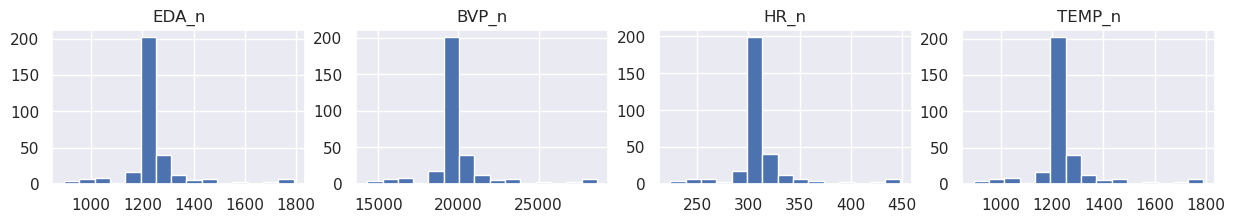

In [14]:
fig, axs = plt.subplots(ncols=4)
fig.set_figheight(2)
fig.set_figwidth(15)
stat_n = ['EDA_n', 'BVP_n', 'HR_n', 'TEMP_n']
min_n = {stat: 0 for stat in stat_n}
for i, colname in enumerate(stat_n):
    min_n[colname] = metadata[colname].min()
    print("Min", metadata[colname[:-1]+'duration'].min(), end=', ')
    axs[i].hist(metadata[colname], bins=15)
    axs[i].set_title(colname)
plt.show()

In [329]:

def get_standardized_signals(stat, n=None, last = True, with_scaling=False):
    if not n:
        n = metadata[['EDA_n', 'BVP_n', 'HR_n', 'TEMP_n']].min()[stat+'_n']

    raw_ds = []
    for path in metadata['Path']:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        if last:
            signal = signal.values[-n:]
        else:
            signal = signal.values[:n]
        raw_ds.append(signal)
    
    raw_ds = pd.DataFrame(raw_ds, index=metadata['Path'])
    scaler = MinMaxScaler()
    scaler.fit(raw_ds.values)
    if with_scaling:
        raw_ds = pd.DataFrame(scaler.transform(raw_ds), index=metadata['Path'])
    
    return raw_ds, scaler

raw_ds, scaler = get_standardized_signals("HR", with_scaling=False)

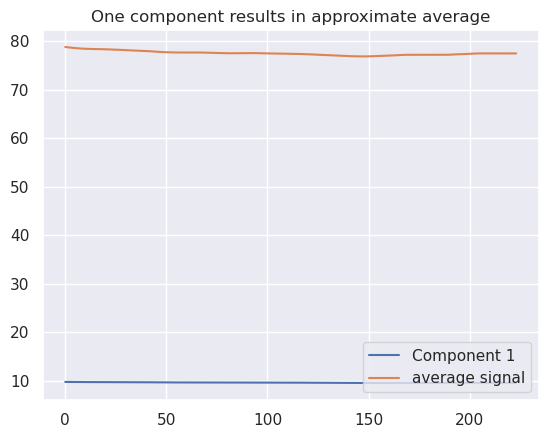

In [330]:
X = raw_ds

model = NMF(n_components=1, init='nndsvda', solver='mu')
W = model.fit_transform(X)
H = model.components_

plt.figure()
plt.title("One component results in approximate average")
plt.plot(H[0, :], label=f"Component 1")
plt.plot(X.mean(axis=0), label='average signal')

plt.legend(loc='lower right')
plt.show()

Iter 178


<Figure size 1000x1000 with 0 Axes>

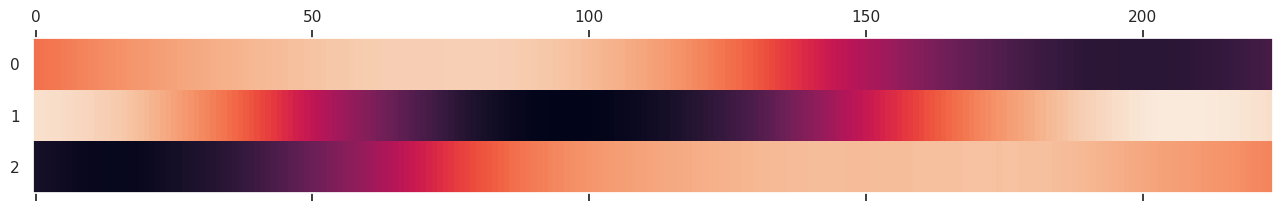

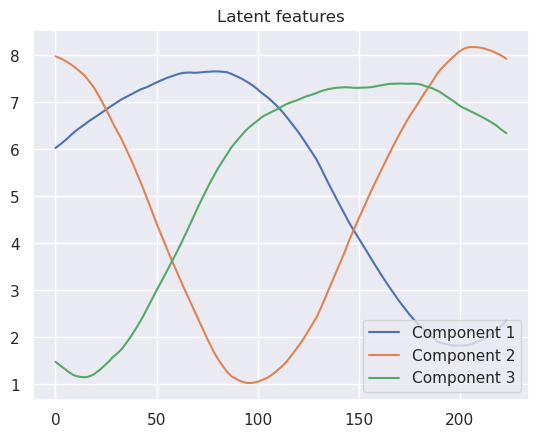

In [331]:
# how many components results in the highest expalined variance while not overfitting?
# by default it doesn't regularize W and H, maybe we should impose some for stability?
X = raw_ds
model = NMF(n_components=3, random_state=100, init='random', solver='cd')
W = model.fit_transform(X)
H = model.components_
print("Iter", model.n_iter_)

plt.figure(figsize=(10, 10))
plt.matshow(H,aspect='auto')
plt.grid(False)
plt.show()

plt.figure()
plt.title("Latent features")
for i in range(H.shape[0]):
    plt.plot(H[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

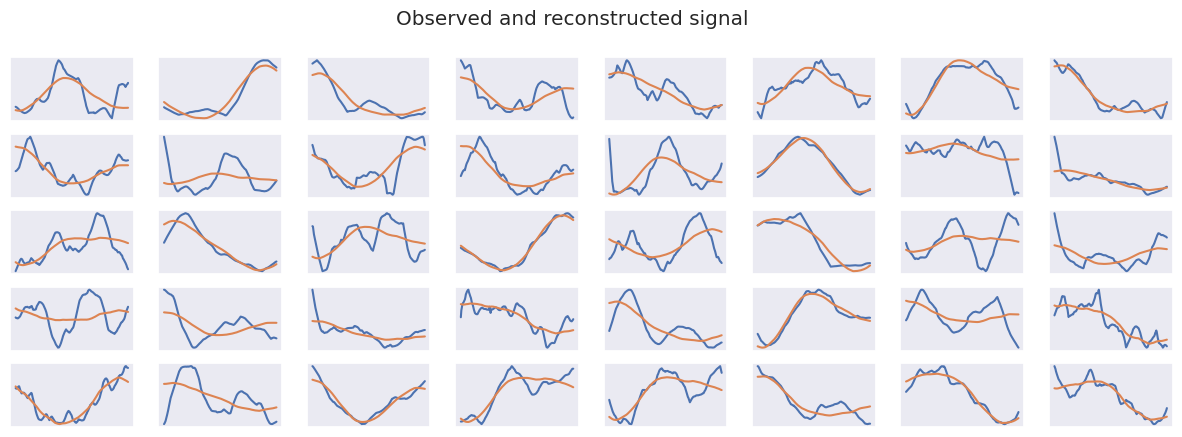

In [336]:
nrows = 5
ncols = 8

fig, axs = plt.subplots(ncols = ncols, nrows=nrows)
fig.set_figwidth(15)
for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols+j
        observed = X.values[idx]
        reconstructed = (W[idx, :]@H)
        axs[i, j].plot(observed)
        axs[i, j].plot(reconstructed)
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        
fig.suptitle("Observed and reconstructed signal")
plt.show()

In [337]:
# to interpret results: 
# 1. describe features with words e.g high, decreasing heart rate
# 2. Is there a difference in how much of each feature contribute to the reconstuction for each phase?

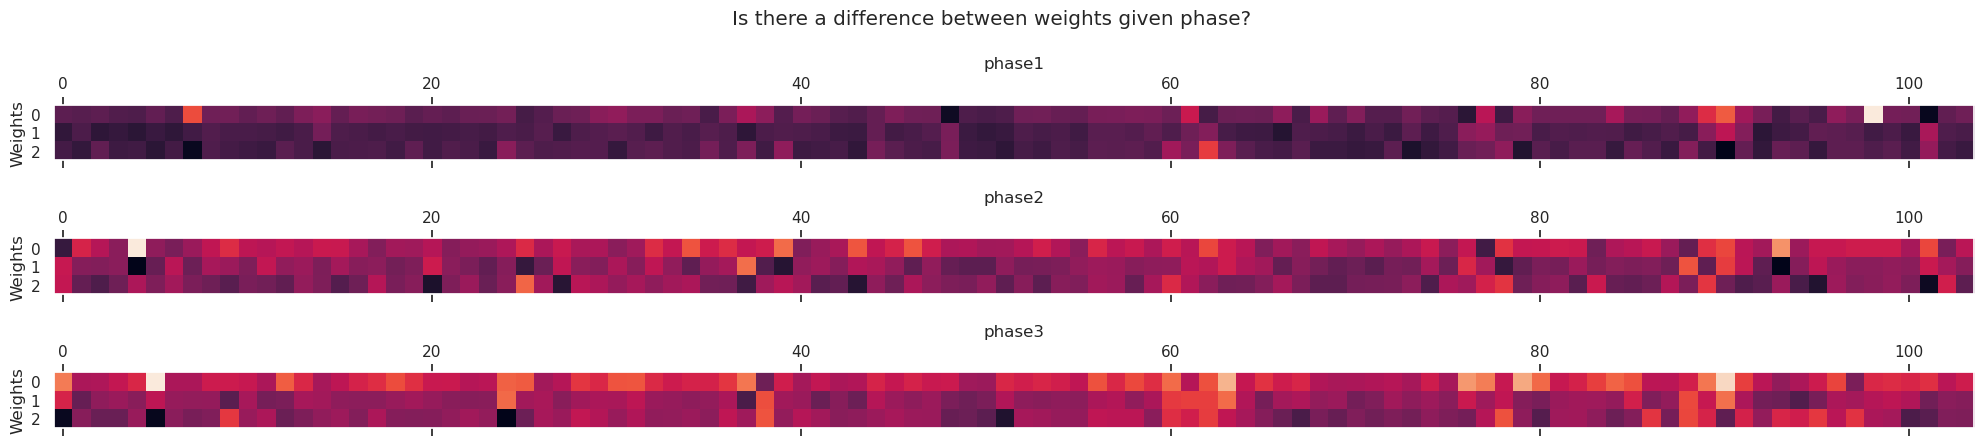

In [338]:
fig, axs = plt.subplots(nrows=3)
fig.set_figwidth(20)
fig.suptitle("Is there a difference between weights given phase?")
for i, phase in enumerate(metadata['Phase'].unique()):
    idxs = metadata['Phase'] == phase
    axs[i].set_title(phase)
    axs[i].matshow(W[idxs, :].T)
    axs[i].grid(False)
    axs[i].set_ylabel("Weights")
    #axs[i].set_xlabel("Observations")
plt.tight_layout()
plt.show()

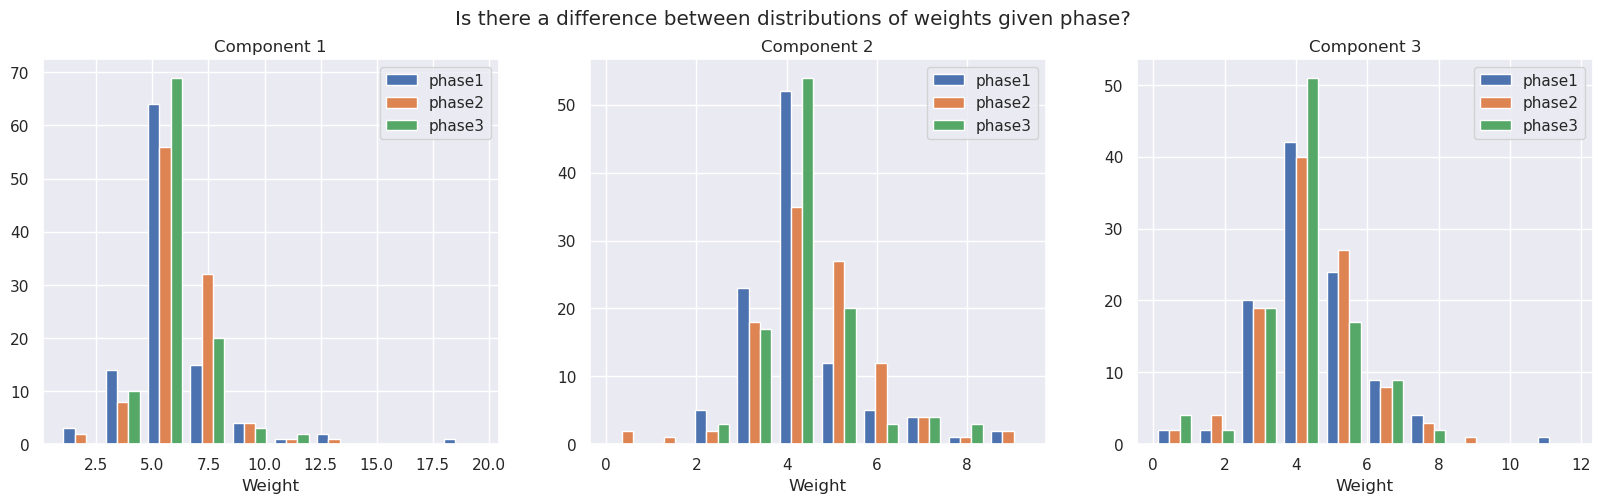

In [339]:
n_comp = W.shape[1]
fig, axs = plt.subplots(nrows=1, ncols=n_comp)
fig.suptitle("Is there a difference between distributions of weights given phase?")
fig.set_figwidth(20)
fig.set_figheight(5)
phases = sorted(metadata['Phase'].unique())
for j in range(n_comp):
    dists = []
    for i, phase in enumerate(phases):
        idxs = metadata['Phase'] == phase
        dists.append(W[idxs, j])
        
    axs[j].hist(dists, label = phases)
    axs[j].set_title(f"Component {j+1}")
    axs[j].set_xlabel("Weight")
    axs[j].legend()

In [340]:
# is there a significant difference between distributions?
components = np.arange(n_comp)
for j in components:
    dists = []
    for i, phase in enumerate(sorted(metadata['Phase'].unique())):
        idxs = metadata['Phase'] == phase
        dists.append(W[idxs, j])
    test = kruskal(*dists)
    #print(test)
    if test.pvalue < 0.05:
        print(f"Weight's for phases are different for component {j+1}")
    else:
        print(f"Weight's for phases are not different for component {j+1}")
        
    # test resting vs puzzling
    dists = [W[metadata['Phase'].isin(["phase1", "phase3"]), j],
             W[metadata['Phase']=="phase2", j]]
    
    test2 = kruskal(*dists)
    if test.pvalue < 0.05:
        print(f"Weight's for resting are different for component {j+1}")
    else:
        print(f"Weight's for resting are not different for component {j+1}")

Weight's for phases are not different for component 1
Weight's for resting are not different for component 1
Weight's for phases are different for component 2
Weight's for resting are different for component 2
Weight's for phases are not different for component 3
Weight's for resting are not different for component 3


In [341]:
#kruskal(np.random.normal(0, 1, 100), np.random.normal(100, 100, 100))

/home/annareisz/miniconda3/envs/CDA/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/annareisz/miniconda3/envs/CDA/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


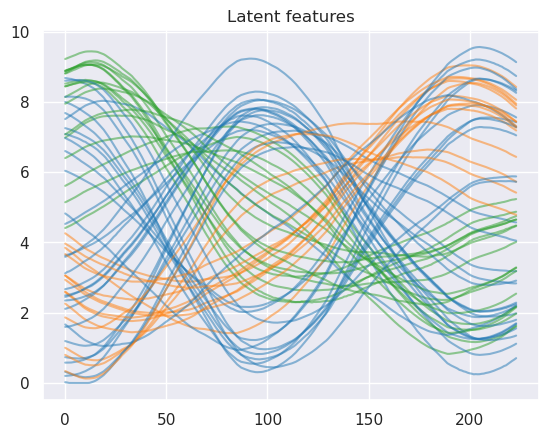

In [342]:
#experiment with different seeds
from matplotlib import colormaps as cmp
cmap = cmp['tab10']
plt.figure()
plt.title("Latent features")
for seed in range(20):
    X = raw_ds.values
    model = NMF(n_components=3, random_state=seed, init='random', solver='cd')
    W = model.fit_transform(X)
    H = model.components_

    for i in range(H.shape[0]):
        if abs(H[i, 100] - H[i, 0]) > 2.5 and abs(H[i, 100] - H[i, -1]) > 2.5:
            color = cmap.colors[0]
        elif H[i, 200] > H[i, 25]:
            color = cmap.colors[1]
        else:
            color = cmap.colors[2]
        plt.plot(H[i, :], color=color, alpha=0.5)
        
plt.show()

# All signals

/home/annareisz/miniconda3/envs/CDA/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


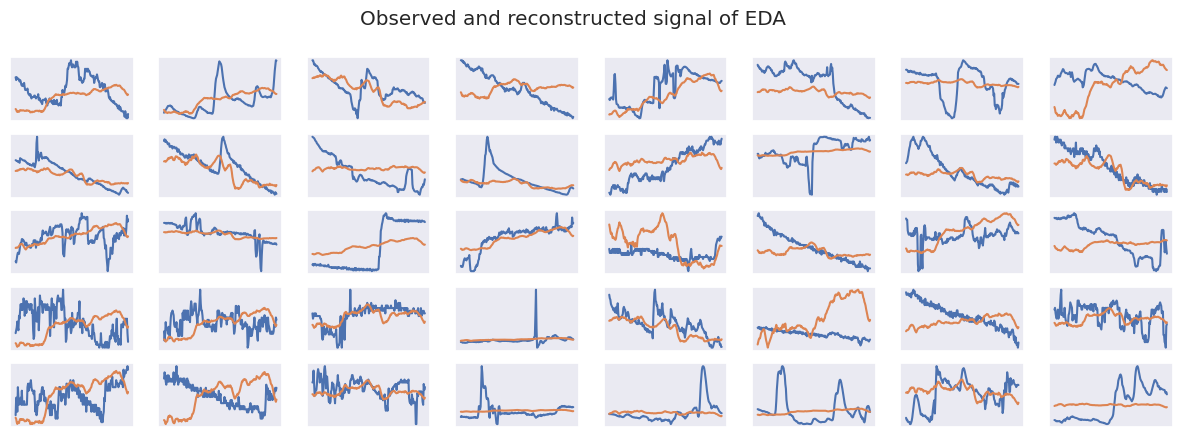

Weight's for cohorts are not different for component 1
Weight's for cohorts are not different for component 2
Weight's for cohorts are not different for component 3


In [369]:
# find weights
# (plot reconstruction)
# (plot wieght dist)
# do kruskal tests

def find_weights(stat, n_comp = 3, seed=100, init='random', solver='cd'):
    normalize = True if stat=='BVP' else False
    raw_ds, scaler = get_standardized_signals(stat, with_scaling=normalize)
    X = raw_ds.values
    model = NMF(n_components=n_comp, random_state=seed, init=init, solver=solver)
    W = model.fit_transform(X)
    H = model.components_
    
    return (X, W, H, model, scaler)

X, W, H, model, scaler = find_weights("EDA")

def plot_reconstruction(X, W, H, stat, scaler=None):
    nrows = 5
    ncols = 8
    Xnew = scaler.inverse_transform(X) if stat=="BVP" else X
    fig, axs = plt.subplots(ncols = ncols, nrows=nrows)
    fig.set_figwidth(15)
    for i in range(nrows):
        for j in range(ncols):
            idx = i*ncols+j
            observed = X[idx]
            reconstructed = (W[idx, :]@H)
            axs[i, j].plot(observed[:200])
            axs[i, j].plot(reconstructed[:200])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])

    fig.suptitle(f"Observed and reconstructed signal of {stat}")
    plt.show()
    
plot_reconstruction(X, W, H, "EDA", scaler)

def plot_components(H, stat):
    plt.figure()
    plt.title(f"Latent features of {stat}")
    for i in range(H.shape[0]):
        plt.plot(H[i, :], label=f"Component {i+1}")
    plt.legend(loc='lower right')
    plt.show()
    
#plot_components(H, "HR")

def plot_weight_dist(W, stat):
    n_comp = W.shape[1]
    fig, axs = plt.subplots(nrows=1, ncols=n_comp)
    fig.suptitle(f"Is there a difference between distributions of weights given phase and {stat}?")
    fig.set_figwidth(20)
    fig.set_figheight(5)
    phases = sorted(metadata['Phase'].unique())
    for j in range(n_comp):
        dists = []
        for i, phase in enumerate(phases):
            idxs = metadata['Phase'] == phase
            dists.append(W[idxs, j])

        axs[j].hist(dists, label = phases)
        axs[j].set_title(f"Component {j+1}")
        axs[j].set_xlabel("Weight")
        axs[j].legend()
        
    plt.show()
    
#plot_weight_dist(W, "HR")

def test_eq_dist(W, test_phases=True, test_resting=True, test_cohorts=True):
    
    def test_dist(col):
        dists = []
        cols = sorted(list(set(x.split('/')[0] for x in metadata['Cohort'].unique())))
        for i, val in enumerate(cols):
            idxs = metadata[col] == val
            dists.append(W[idxs, j])
        return kruskal(*dists)
    
    def pretty_print(pval, test_name, j):
        if pval < 0.05:
            print(f"Weight's for {test_name} are different for component {j+1}")
        else:
            print(f"Weight's for {test_name} are not different for component {j+1}")
        
        
    n_comp = W.shape[1]
    components = np.arange(n_comp)
    for j in components:
        
        
        if test_phases:
            test = test_dist("Phase")
            pretty_print(test.pvalue, "phases", j)


        if test_resting:
            dists = [W[metadata['Phase'].isin(["phase1", "phase3"]), j],
                     W[metadata['Phase']=="phase2", j]]

            test = kruskal(*dists)
            pretty_print(test.pvalue, "resting", j)
                
        if test_cohorts:
            test = test_dist("Cohort")
            pretty_print(test.pvalue, "cohorts", j)
            

test_eq_dist(W, test_phases=False, test_resting=False)


In [362]:
signals = ["HR", "EDA", "TEMP"]
for stat in signals:
    print(stat)
    X, W, H, model = find_weights(stat, 3)
    #plot_components(H, stat)
    #plot_reconstruction(X, W, H, stat)
    #plot_weight_dist(W, stat)
    test_eq_dist(W, test_phases=False, test_resting=True, test_cohorts=False)

HR
Weight's for resting are not different for component 1
Weight's for resting are different for component 2
Weight's for resting are not different for component 3
EDA


/home/annareisz/miniconda3/envs/CDA/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Weight's for resting are not different for component 1
Weight's for resting are not different for component 2
Weight's for resting are not different for component 3
TEMP
Weight's for resting are not different for component 1
Weight's for resting are not different for component 2
Weight's for resting are not different for component 3


In [363]:
X, W, H, model = find_weights("BVP")



/home/annareisz/miniconda3/envs/CDA/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


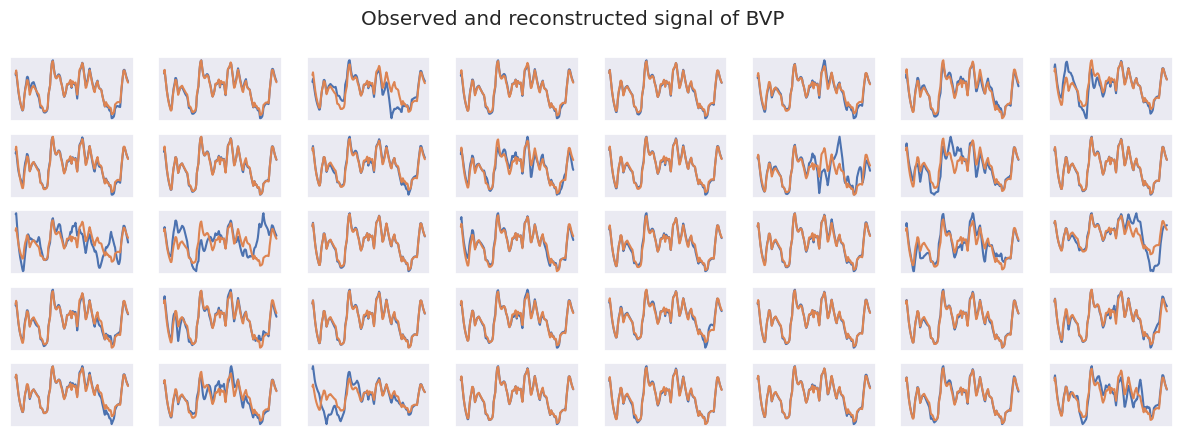

In [364]:
plot_reconstruction(X, W, H, "BVP", scaler)